In [11]:
from selenium import webdriver
import pandas as pd
import time
import itertools
import pprint
import json
import re
from IPython.display import display
from IPython.display import clear_output
from matplotlib import pyplot as plt
pd.set_option('display.max_colwidth', -1)
plt.rcParams['figure.figsize'] = [15, 7.5]

In [2]:
driver = webdriver.Chrome('/usr/bin/chromedriver')

# get all settlements links

In [ ]:
driver.get('https://www.gov.il/he/departments/news/?OfficeId=104cb0f4-d65a-4692-b590-94af928c19c0&limit=10&topic=3ef9cac8-a1a9-4352-91d4-860efd3b720d&subTopic=626a30f9-8b50-495a-9b9f-e4ce4b433ca5')

In [ ]:
settlements_url_list_of_lists = []
while True:
    series = pd.Series(driver.page_source.split(' '))
    settlements_url_list = series[series.str.contains('-corona')].apply(lambda x: x[6:-1]).tolist()
    settlements_url_list_of_lists.append(settlements_url_list)
    element = driver.find_elements_by_xpath("//div[contains(@class, 'button-gov blue xs-pl-5 xs-pr-5')]")[1]
    if element.is_displayed():
        element.click()
        time.sleep(0.25)
    else:
        break

In [ ]:
all_settlements_list = list(itertools.chain.from_iterable(settlements_url_list_of_lists))
all_settlements_series = pd.Series(pd.Series(all_settlements_list).unique())
display(all_settlements_series.shape)
display(all_settlements_series.head())

In [ ]:
all_settlements_csv_path = './all_settlements_links.csv'
all_settlements_series.to_csv(all_settlements_csv_path, index=False, header=False)
# all_settlements_series = pd.read_csv(all_settlements_csv_path, header=None)[0]
display(all_settlements_series.head())
display(all_settlements_series.shape)

# get settlements datums

In [ ]:
def get_settlement_data(driver):
    main_xpath = '//div[@class=\'margin-for-ul txt dark-gray-txt lg-mb-30 tbl-accesabilty tbl-responsive sub-links-permanent-underline\']//'
    xpath = f'{main_xpath}h3 | {main_xpath}h2 | {main_xpath}p | {main_xpath}li'
    elements_list = driver.find_elements_by_xpath(xpath)
    datum_list = [element.text for element in elements_list]
    b = pd.Series(datum_list)
    datum_clean_list = b[:b[b.str.contains('הנחיות לציבור')].index[0]].tolist()
    return datum_clean_list

In [ ]:
all_settlements_dict = {}

for index, settlement_link in enumerate(all_settlements_series):        
    driver.get(settlement_link)
    time.sleep(0.25)
    clear_output(wait=True) 
    settlement_datum_list = get_settlement_data(driver)
    all_settlements_dict[settlement_link] = {'title': driver.title, 'datum': settlement_datum_list}    
    print(f'{index + 1} / {len(all_settlements_series)}: {settlement_link}')
    print(all_settlements_dict[settlement_link])

In [ ]:
json_path = 'all_settlements_dict.json'
with open(json_path, 'w') as fp:
    json.dump(all_settlements_dict, fp)
# with open(json_path, 'r') as fp:
#     all_settlements_dict = json.load(fp)

# extract incident date

In [ ]:
def get_update_date_if_update(row):
    if 'עדכון' in re.findall('עדכון|עודכן', row['raw']):
        return get_date_from_string(row['raw'])
    else:
        return None

In [ ]:
def get_date_from_string(string):
    date_strings_list = re.findall('\d{1,2}\.\d{1,2}\.\d{1,4}|\d{1,2}/\d{1,2}/\d\d', string)
    if date_strings_list:
        if date_strings_list[0] == '30.30.2020':
            date_strings_list[0] = '30.3.2020'        
#         print(string, date_strings_list[0])
        date = pd.to_datetime(date_strings_list[0], dayfirst=True)
    else:
        date_strings_list_2 = re.findall('\d{1,2}\.\d{1,2}', string)
        if date_strings_list_2:
            if date_strings_list_2[0] == '24.32':
                date_strings_list_2[0] = '24.3'
            date = pd.to_datetime(date_strings_list_2[0] + '.20', dayfirst=True)
        else:
            date = None
    return date

In [ ]:
def get_settlement_df(settlement_link, settlement_dict):
    settlement_name = " ".join(settlement_dict['title'].split()[:-9])
    df = pd.Series(settlement_dict['datum']).to_frame('raw')
    df['update_date_temp'] = df.apply(get_update_date_if_update, axis=1)
    df['update_date'] = df['update_date_temp'].ffill()
    clean_df = df[~df['update_date_temp'].notna()][['raw', 'update_date']].dropna(subset=['update_date'])
    clean_df['incident_day'] = clean_df['raw'].apply(get_date_from_string)
    clean_df['settlement_name'] = settlement_name
    clean_df['settlement_link'] = settlement_link
    return clean_df

In [ ]:
temp_df = [get_settlement_df(key, value) for key, value in all_settlements_dict.items()]
incidents_df = pd.concat(temp_df).reset_index(drop=True)
incidents_df.head()

In [ ]:
incidents_df[incidents_df['incident_day'] == '2020-04-29']

In [ ]:
incidents_df[incidents_df['incident_day'] == '2020-01-04']

In [42]:
incidents_csv_path = './incidents.csv'
# incidents_df.to_csv(incidents_csv_path, index=False)
incidents_df = pd.read_csv(incidents_csv_path, parse_dates=['update_date', 'incident_day']).dropna()
incidents_df.head()

,raw,update_date,incident_day,settlement_name,settlement_link
0,"20/04/2020 07:45 - 08:00 מכולת אלחלאן, סח'נין",2020-04-24,2020-04-20,סח'נין,https://www.gov.il/he/departments/news/sakhnin-corona
1,"17/04/2020 10:00 - 11:30 הום סנטר, ירכא",2020-04-24,2020-04-17,ירכא,https://www.gov.il/he/departments/news/yarka-corona
2,"10/04/2020 11:00- 13:00 מכולת ח'ריס מולא- ליד בניין מועצה מקומית , ירכא",2020-04-23,2020-04-10,ירכא,https://www.gov.il/he/departments/news/yarka-corona
3,"13/04/2020 20:30- 22:30 מרכז המזון , ירכא",2020-04-21,2020-04-13,ירכא,https://www.gov.il/he/departments/news/yarka-corona
4,"11.4.20, 10:00-13:00 - מרכז המזון ירכא, ירכא",2020-04-17,2020-04-11,ירכא,https://www.gov.il/he/departments/news/yarka-corona


# statistics

In [25]:
incidents_stat_df = incidents_df.groupby('incident_day').size().to_frame('size').reset_index()

In [26]:
incidents_clean_stat_df = incidents_stat_df[(incidents_stat_df['incident_day'] >= '2020-03-01') & (incidents_stat_df['incident_day'] <= '2020-04-24')]
incidents_clean_stat_df.sample(5)

,incident_day,size
1,2020-03-01,6
48,2020-04-19,17
31,2020-04-02,173
23,2020-03-25,479
8,2020-03-10,59


Text(0, 0.5, 'number of incidents')

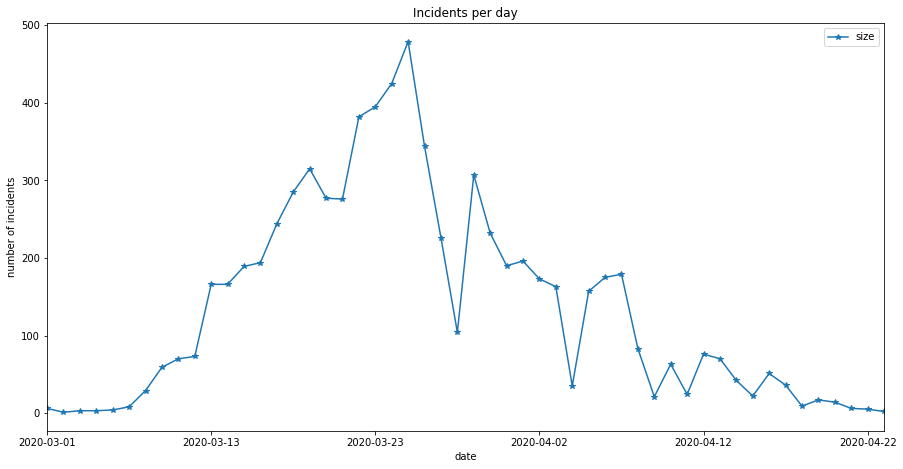

In [27]:
incidents_clean_stat_df.plot(x='incident_day', y='size', marker='*')
plt.title('Incidents per day')
plt.xlabel('date')
plt.ylabel('number of incidents')

# Cities

In [28]:
def check_name(df, name):
    settlement_names_series = df['settlement_name']
    return settlement_names_series[settlement_names_series.str.contains(name)].unique()

In [29]:
def show_stat(df, settlement_name):
    print(check_name(df, settlement_name))
    settlement_df = df[df['settlement_name'].str.contains(settlement_name)]
    stat_df = settlement_df.groupby('incident_day').size().to_frame('size').reset_index()
    stat_df.plot(x='incident_day', y='size', marker='*')
    plt.title('Incidents per day')
    plt.xlabel('date')
    plt.ylabel('number of incidents')

['בני ברק']


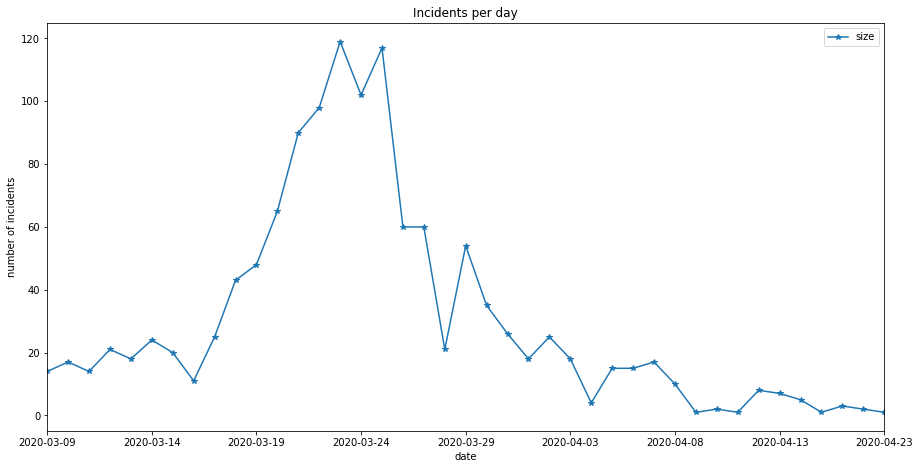

In [30]:
show_stat(incidents_df, 'בני ברק')

['פתח תקווה (פתח תקוה)']


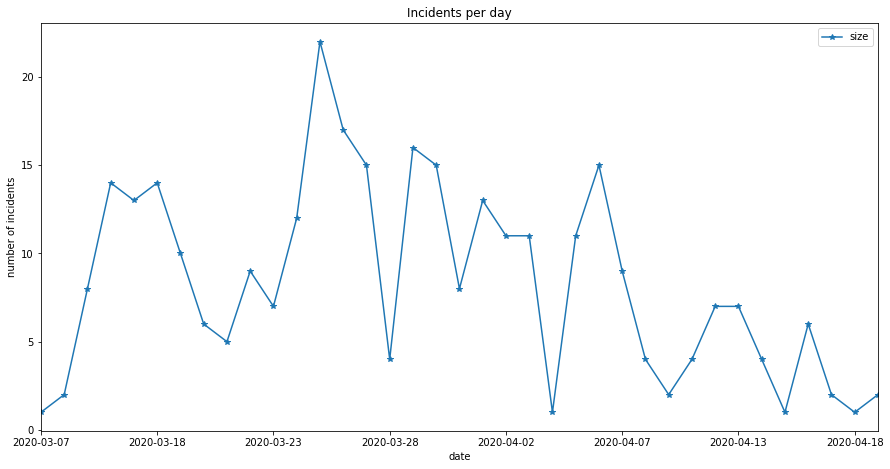

In [31]:
show_stat(incidents_df, 'פתח')

['כפר סבא']


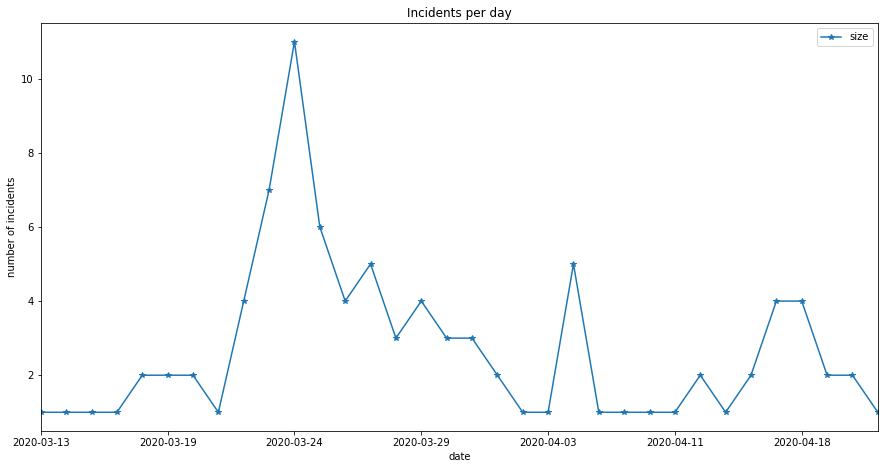

In [32]:
show_stat(incidents_df, 'כפר סבא')

['תל אביב -']


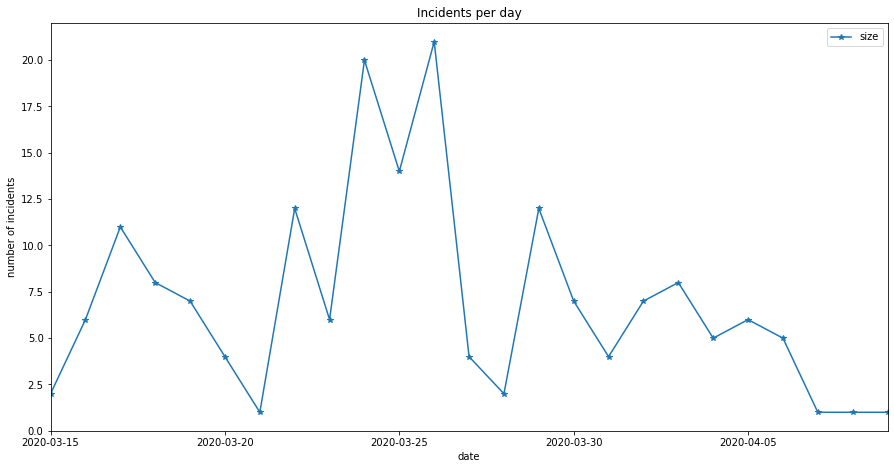

In [33]:
show_stat(incidents_df, 'תל אביב')

['ירושלים והסביבה']


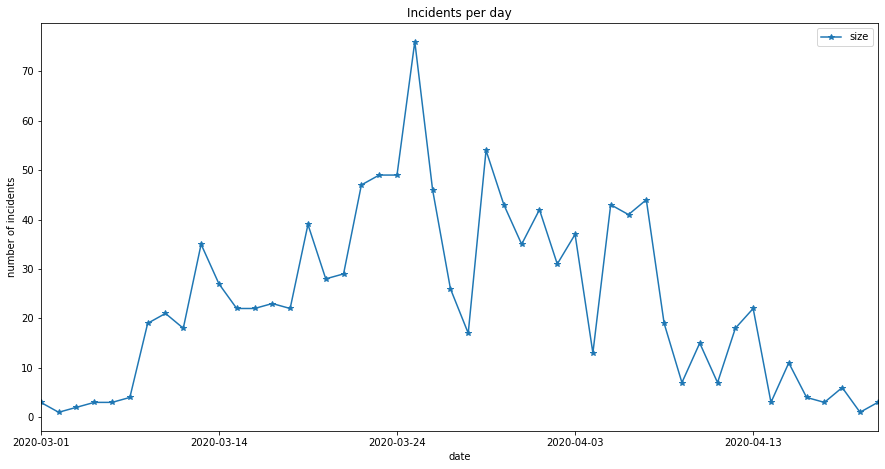

In [34]:
show_stat(incidents_df, 'ירושלים')

['חיפה']


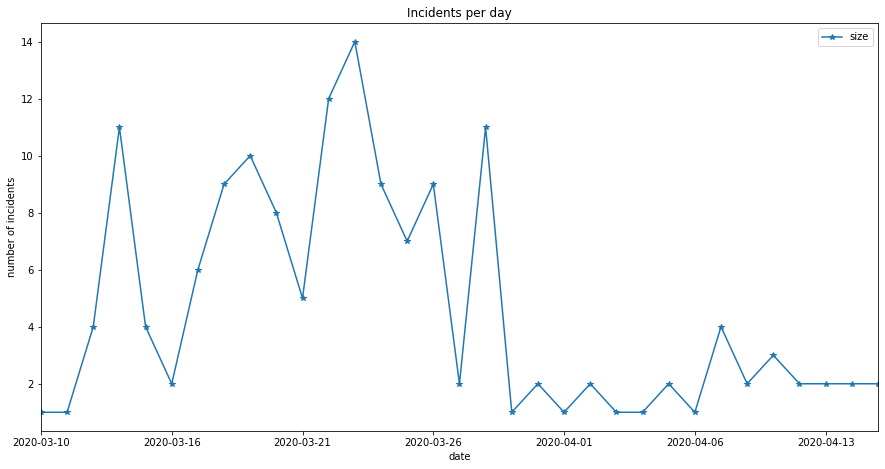

In [35]:
show_stat(incidents_df, 'חיפה')

In [51]:
incidents_df['incident_to_update_days_diff'] = incidents_df['update_date'] - incidents_df['incident_day']
incidents_df.head()

,raw,update_date,incident_day,settlement_name,settlement_link,incident_to_update_days_diff
0,"20/04/2020 07:45 - 08:00 מכולת אלחלאן, סח'נין",2020-04-24,2020-04-20,סח'נין,https://www.gov.il/he/departments/news/sakhnin-corona,4 days
1,"17/04/2020 10:00 - 11:30 הום סנטר, ירכא",2020-04-24,2020-04-17,ירכא,https://www.gov.il/he/departments/news/yarka-corona,7 days
2,"10/04/2020 11:00- 13:00 מכולת ח'ריס מולא- ליד בניין מועצה מקומית , ירכא",2020-04-23,2020-04-10,ירכא,https://www.gov.il/he/departments/news/yarka-corona,13 days
3,"13/04/2020 20:30- 22:30 מרכז המזון , ירכא",2020-04-21,2020-04-13,ירכא,https://www.gov.il/he/departments/news/yarka-corona,8 days
4,"11.4.20, 10:00-13:00 - מרכז המזון ירכא, ירכא",2020-04-17,2020-04-11,ירכא,https://www.gov.il/he/departments/news/yarka-corona,6 days


In [52]:
incidents_df['incident_to_update_days_diff'].describe()

count    7073                    
mean     -3 days +09:51:50.363353
std      281 days 15:38:53.176527
min      -6571 days +00:00:00    
25%      7 days 00:00:00         
50%      10 days 00:00:00        
75%      12 days 00:00:00        
max      92 days 00:00:00        
Name: incident_to_update_days_diff, dtype: object

In [59]:
incidents_df.loc[incidents_df['incident_to_update_days_diff'].idxmin()]

raw                             23/03/2020 08:00- 08:00, סופר סל , אופקים           
update_date                     2002-03-27 00:00:00                                 
incident_day                    2020-03-23 00:00:00                                 
settlement_name                 אופקים                                              
settlement_link                 https://www.gov.il/he/departments/news/ofakim-corona
incident_to_update_days_diff    -6571 days +00:00:00                                
Name: 7251, dtype: object

In [60]:
incidents_df.loc[incidents_df['incident_to_update_days_diff'].idxmax()]

raw                             4/1/2020 9:30 - 18:00 הוסטל בית גיא רח' פנחס בן דוד 5       
update_date                     2020-04-05 00:00:00                                         
incident_day                    2020-01-04 00:00:00                                         
settlement_name                 ראשון לציון                                                 
settlement_link                 https://www.gov.il/he/departments/news/-rishon-lezion-corona
incident_to_update_days_diff    92 days 00:00:00                                            
Name: 6438, dtype: object

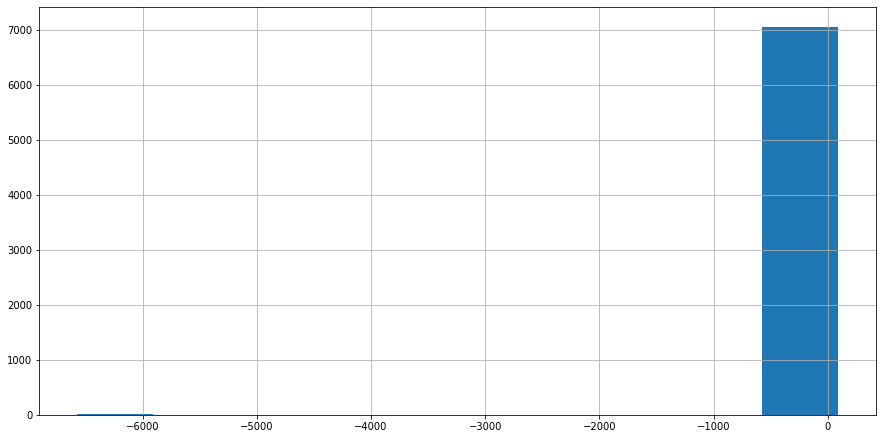

In [63]:
incidents_df['incident_to_update_days_diff'].dt.days.hist()

Text(0, 0.5, 'count')

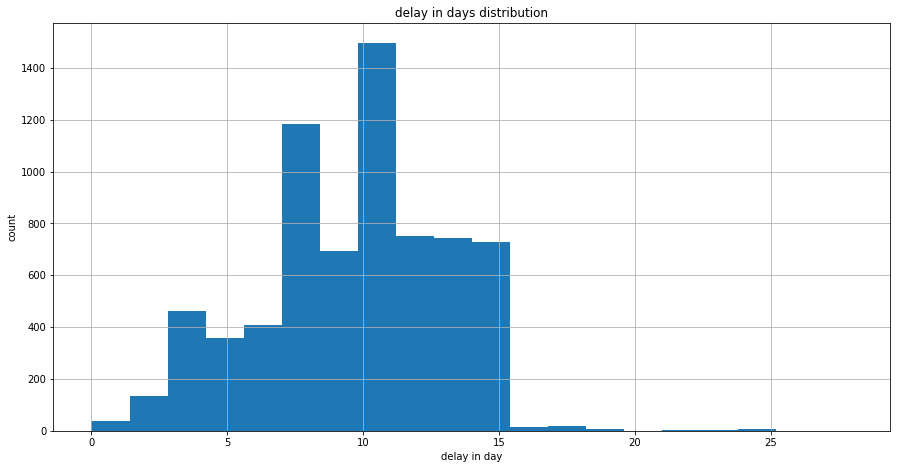

In [76]:
a = incidents_df['incident_to_update_days_diff'].dt.days
b = a[(a >= 0) & (a < 50)]
b.hist(bins=20)
plt.title('delay in days distribution')
plt.xlabel('delay in day')
plt.ylabel('count')